In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-01-08 08:41:01--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-01-08 08:41:01 (13.3 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
    # read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  """
      Class work as a linear layer
  """
  def __init__(self, fan_in, fan_out, bias=True): 
    """
        Object Initialization for the weight and bias.
        Input:
            - fan_in: nomber of inputs
            - fan_out: number of output
            - bias: weather you want bias or not.
        Output:
             - Tensors for bias and weight

      """
#when the bias will be None?
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    """
        Calculate creates Linear mathimatical.
        Input:
            - x: input data
        Output:
             - x @ weight + bias

    """
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    """
        Creates list for weights and bias.
        Output:
             - list for bias and weight

    """
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  """
      Applies Batch noralization over the data
  """
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    """
      Object Initialization.
      Input:
          - dim: dim number
          - eps: used to avoid division by zero
          - momentum: used to keep tracking of the runing mean and std.
          - gamma and beta: parameters for BatchNorm1d.
          - running_mean, running_var: buffers(not parameter of this layer) 
            trained using exponential moving avarage(not part of backpropagation)
    """
    self.eps = eps#saving eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    """
      Object Initialization.
      Input:
          - x: input data
      Output:
            - the data after normalization

    """
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim  = (0, 1)
      #while training we will use the mean and variance estimated from current batch
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      #while evaluation we will use the running_mean and running_var estimated from current batch
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        #while training we will ubdate running_var, running_mean, but while testing will not be updated.
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  """
      Calculate the tanh
  """
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []#have no parameter

#-----------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
#-----------------------------------------------------------------------------
class FlattenConsecutive:
# n: number of consecutive elements  we wnat to concatenete
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  def parameters(self):
    return []
#-----------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

#C = torch.randn((vocab_size, n_embd),            generator=g)
#stack the layers up as a list as multi_layer perceptron
#----------------with batchnormalization-----------------------
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])
with torch.no_grad():
  # last layer: make less confident of the softmax
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = [] 

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad


  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



      0/ 200000: 3.2973
  10000/ 200000: 1.7464
  20000/ 200000: 1.7888
  30000/ 200000: 1.9589
  40000/ 200000: 2.1329
  50000/ 200000: 1.9487
  60000/ 200000: 2.1313
  70000/ 200000: 1.6079
  80000/ 200000: 1.8670
  90000/ 200000: 2.3589
 100000/ 200000: 2.1312
 110000/ 200000: 1.4416
 120000/ 200000: 1.8272
 130000/ 200000: 2.2844
 140000/ 200000: 1.7971
 150000/ 200000: 2.0377
 160000/ 200000: 1.7928
 170000/ 200000: 1.8039
 180000/ 200000: 2.3848
 190000/ 200000: 1.4510


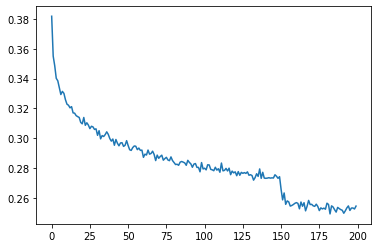

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7637085914611816
val 1.988756775856018


### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.94, val 2.030
- fix bug in batchnorm: train 1.909, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.763, val 1.988


In [ ]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

bless.
fatif.
brissam.
kyrabel.
prish.
faw.
narius.
jezika.
silveris.
sajen.
ana.
auston.
ronita.
salima.
giare.
diana.
robbet.
jasmeno.
kaysen.
ayla.


## Debugging what happend inside the BatchNorlalization

In [ ]:
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim = True) #1, 4, 68
evar = e.var((0, 1), keepdim = True) #1, 4, 68
ehat = (e - emean)/torch.sqrt(evar + 1e-5) #32, 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [ ]:
model.layers[3].running_mean.shape #we should have only 68 but now batchnorm working parallel on 4 of
#68 channels so we wnat to find the mean and var for tuple of (32, 4) so
# we will change e.mean(0, keepdim = True) to e.mean((0, 1), keepdim = True) so the out 
#  #1, 1, 68
# the running_mean will be the same only the dim = 4 is an spurious dim
# so we only maintaining the mean and var for 68 channels

torch.Size([1, 4, 68])

# Debugging what happend inside the model

In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb  = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 12,  5,  5, 12,  5, 14],
        [ 0,  0,  0,  0,  0,  0,  3,  1]])

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [ ]:
model.layers[0].out.shape #output of embedding layer

torch.Size([4, 8, 10])

In [ ]:
model.layers[1].out.shape #output of flatten layer

torch.Size([4, 80])

In [ ]:
model.layers[2].out.shape #output of linear layer

torch.Size([4, 200])

In [ ]:
(torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200)).shape #how linear layer works

torch.Size([4, 200])

In [ ]:
# now we have 8 numbers and we wnat to fuse each two numbers 
# so what we have done is we create 4 groups in each (4, 20) 
# we should change the flatten layer to give us (4, 4, 20)
(torch.randn(4, 4, 20) @ torch.randn(20,200) + torch.randn(200)).shape #how linear layer works

In [ ]:
# (1 2) (3 4) (5 6) (7 8) 